In [190]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In [191]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('Dữ liệu Lịch sử DXG.csv')

# Đặt lại tên cột
data.columns=[ 'Date', 'Close', 'Open', 'High', 'Low', 'Vol', 'Change']


# data = pd.DataFrame(data)

# Tiền xử lý dữ liệu
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['Close'] = data['Close'].apply(lambda x: float(x.replace(",", "")))
data['Open'] = data['Open'].apply(lambda x: float(x.replace(",", "")))
data['High'] = data['High'].apply(lambda x: float(x.replace(",", "")))
data['Low'] = data['Low'].apply(lambda x: float(x.replace(",", "")))
data['Vol'] = data['Vol'].apply(lambda x: float(x.rstrip('M').rstrip('K')) * 1e6 if 'M' in x else float(x.rstrip('K')) * 1e3)

# Sắp xếp dữ liệu tăng dần theo cột Date
data = data.sort_values('Date')

In [192]:
#Xem lại dữ liệu sau khi xử lý hoàn tất
data

,Date,Close,Open,High,Low,Vol,Change
1348,2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,2.79%
1347,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,3.70%
1346,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-3.33%
1345,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.99%
1344,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.50%
...,...,...,...,...,...,...,...
4,2023-04-24,12750.0,12500.0,12850.0,12500.0,7780000.0,0.79%
3,2023-04-25,12550.0,12950.0,12950.0,12550.0,10090000.0,-1.57%
2,2023-04-26,12600.0,12600.0,12700.0,12400.0,7820000.0,0.40%
1,2023-04-27,13200.0,12700.0,13450.0,12600.0,30210000.0,4.76%


In [193]:
# Chia dữ liệu thành tập huấn luyện, tập validation và tập kiểm tra
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [226]:
# Tạo ma trận dữ liệu
X_train = train_data[['High', 'Low','Close', 'Open', 'Vol']].values
X_val = val_data[['High', 'Low' , 'Close', 'Open', 'Vol']].values
X_test = test_data[['High', 'Low', 'Close', 'Open', 'Vol']].values

y_train = train_data['Close'].values
y_val = val_data['Close'].values
y_test = test_data['Close'].values


In [227]:
# Duyệt qua các giá trị k_factors và factor_order để tìm giá trị tối ưu
best_score = float('inf')
best_k_factors = 0
best_factor_order = 0

for k_factors in range(1, 4):
    for factor_order in range(1, 5):
        # Xây dựng The Dynamic Factor Model
        model = sm.tsa.DynamicFactor(X_train, k_factors=k_factors, factor_order=factor_order)
        result = model.fit()

        # Dự đoán giá cổ phiếu trên tập validation
        y_pred = result.predict(start=train_size, end=train_size+test_size-1)

         # Lấy cột close từ y_pred để tính toán độ chính xác
        y_pred_close = y_pred[:, 2]

        # Đánh giá độ chính xác dự đoán trên tập test
        score = np.mean((y_pred_close - y_test)**2)

        # Lưu lại giá trị tốt nhất
        if score < best_score:
            best_score = score
            best_k_factors = k_factors
            best_factor_order = factor_order

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-227-172bbc74e707>:19: RuntimeWarning: overflow encountered in square
  score = np.mean((y_pred_close - y_test)**2)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/d

In [228]:
best_score

239813379.46097788

In [229]:
best_k_factors

3

In [230]:
best_factor_order

4

In [231]:

# Xây dựng The Dynamic Factor Model với giá trị tối ưu
model = sm.tsa.DynamicFactor(X_train, k_factors=best_k_factors, factor_order=best_factor_order)
result = model.fit()
# Dự đoán giá cổ phiếu trên tập kiểm tra
y_pred_test = result.predict(start=train_size, end=train_size+test_size)

# Dự đoán giá cổ phiếu trên tập kiểm tra
y_pred_val = result.predict(start=train_size+test_size, end=len(data)-1)



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


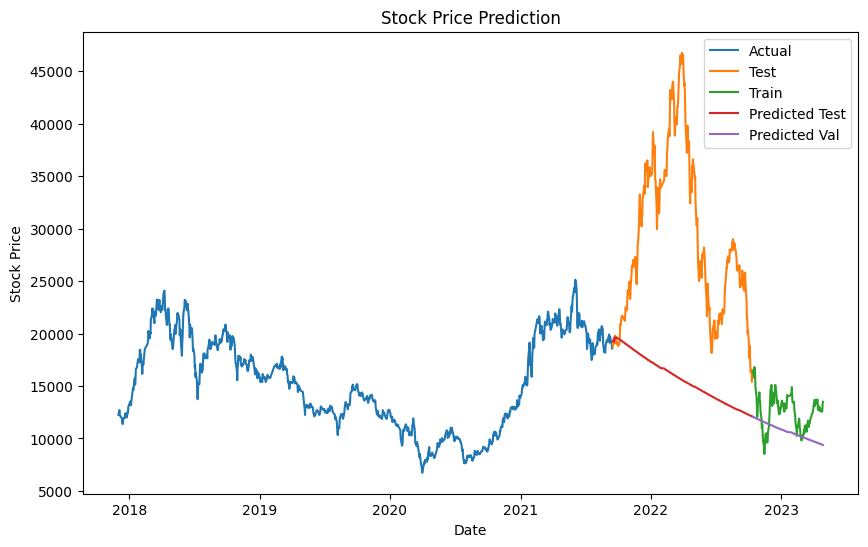

In [232]:

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:train_size], train_data['Close'], label='Actual')
plt.plot(data['Date'][train_size:train_size+test_size], test_data['Close'], label='Test')
plt.plot(data['Date'][train_size+test_size:], val_data['Close'], label='Train')

plt.plot(data['Date'][train_size:train_size+test_size+1], y_pred_test[:,2], label='Predicted Test')
plt.plot(data['Date'][train_size+test_size:], y_pred_val[:,2], label='Predicted Val')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


In [233]:
# Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val[:,2] - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test[1:,2] - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 2534.15582694001
Testing RMSE: 15510.832025988233
